# SETUP


In [29]:
# TA-LIB
!wget https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!sudo make install
%cd /content
#

--2022-01-28 11:53:00--  https://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-01-28 11:53:00--  https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving iweb.dl.sourceforge.net (iweb.dl.sourceforge.net)... 192.175.120.182, 2607:f748:10:12::5f:2
Connecting to iweb.dl.sourceforge.net (iweb.dl.sourceforge.net)|192.175.120.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330299 (1.3M) [application/x-gzip]
Saving to: ‘ta-lib-0.4.0-src.tar.gz.3’

ta-lib-0.4.0-src.ta 100%[===================>]   1.27M  2.44MB/s    in 0.5s    

2022-01-28 11:53:01 (2.44 M

In [30]:
!pip uninstall -y matplotlib imgaug
!pip install backtrader matplotlib==3.2.2 seaborn TA-Lib hyperopt backtrader-plotting yfinance plotly


Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
  Using cached matplotlib-3.2.2-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)


In [2]:
import sys
import datetime
from datetime import date
import re
import glob
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import backtrader as bt     # Import the backtrader platform
from backtrader_plotting import Bokeh
import plotly.express as px

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from pandas_datareader import data as pdr

import requests
import json
import numpy as np
import time

import yfinance as yf
yf.pdr_override()

IS_IN_COLAB = 'google.colab' in sys.modules


In [3]:
# Convert function
def get_range_arr(val_from, val_to, mult=None):
  if(mult):
    return [val * mult for val in range(val_from, val_to + 1)]
  return [val for val in range(val_from, val_to + 1)]

# BASE PARAMETERS

In [4]:
#@title TICKET AND DATAFRAME
TICKER = "DODOUSDTPERP" #@param {type:"string"}
TIME_FRAME = "15m" #@param {type:"string"}
FROM_DATE =  "2021-06-10" #@param {type:"string"}
ITERATIONS = 100 #@param {type:"integer"}

# GET DATA

In [5]:
# init data
FN_TICKERS_REGEXP = f'({TICKER}\,\s*{TIME_FRAME}\.csv$)|({TICKER}_{TIME_FRAME}.csv$)'
all_dir = glob.glob('./*.csv', recursive=False) + glob.glob('./data/*.csv', recursive=False)
files_for_ticker = [fn for fn in all_dir if re.search(FN_TICKERS_REGEXP, fn, re.I)]
is_data_has_volume = True

class TVPandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume' if is_data_has_volume else None),
        ('openinterest', None),
    )

class YFPandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('adjclose', 'Adj Close'),
        ('openinterest', None),
    )
max_val = 0
if files_for_ticker:
    datapath = files_for_ticker[0]
    if (not ',' in datapath):
        data = bt.feeds.YahooFinanceCSVData(dataname=datapath, reverse=False,
                                            fromdate=date.fromisoformat(FROM_DATE)
                                            # datetime.datetime(2020, 8, 1),     # # Do not pass values before this date
                                            # todate=datetime.datetime(2000, 12, 31),      # Do not pass values after this date
                                            )
    else:
        df = pd.read_csv(datapath, header=0, encoding='utf-8', sep=',')
        df['time'] = pd.to_datetime(df['time'] ,unit='s')
        is_data_has_volume = 'volume' in df.columns
        df_filtered = df[df['time'] > pd.to_datetime(FROM_DATE)]
        df = df_filtered.reset_index().set_index('time')
        max_val = df['high'].max()
        data = TVPandasData(dataname=df, name=TICKER.lower())

else:
    if 'perp' in TICKER.lower() or 'usdt' in TICKER.lower():

        from_date_val = datetime.datetime.fromisoformat(FROM_DATE)
        start_time = int(from_date_val.timestamp() * 1000)

        df = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        opentime, lopen, lhigh, llow, lclose, lvol, closetime = [], [], [], [], [], [], []

        cur_time = datetime.datetime.utcnow()
        cur_time = cur_time.replace(minute=0, second=0, microsecond=0)
        cur_time = int(cur_time.timestamp()) * 1000 - 1

        if ('perp' in TICKER.lower()):
            api_url = f'https://fapi.binance.com/fapi/v1/continuousKlines?pair={TICKER[:-len("perp")]}&interval={TIME_FRAME.lower()}&contractType=PERPETUAL&limit=1000'
        else:
            api_url = f'https://fapi.binance.com/fapi/v1/klines?symbol={TICKER}&interval={TIME_FRAME.lower()}&limit=1000'
        while (start_time < cur_time):
            print(f'Get 1000 candles for {TICKER}:{TIME_FRAME} from the datetime {datetime.datetime.utcfromtimestamp(int(start_time / 1000))}')
            sym_info = requests.get(f"{api_url}&startTime={start_time}")
            if (sym_info.status_code == 429):
                raise InterruptedError(f'Limits is violated')
            elif (sym_info.status_code != 200):
                raise InterruptedError(f'Error for request. Code {sym_info.status_code}')
            candles = json.loads(sym_info.text)
            for candle in candles:
                opentime.append(candle[0])
                lopen.append(candle[1])
                lhigh.append(candle[2])
                llow.append(candle[3])
                lclose.append(candle[4])
                lvol.append(candle[5])
                closetime.append(candle[6])
            start_time = closetime[-1]
            time.sleep(1)

        df['open_time'] = pd.to_datetime(opentime, unit='ms', origin='unix')
        df['time'] = df['open_time'].apply(lambda x: int(x.timestamp()))
        df['open'] = np.array(lopen).astype(float)
        df['high'] = np.array(lhigh).astype(float)
        df['low'] = np.array(llow).astype(float)
        df['close'] = np.array(lclose).astype(float)
        df['volume'] = np.array(lvol).astype(float)
        df.to_csv(f'./{TICKER}, {TIME_FRAME}.csv', header=True, index=False, date_format='%s', encoding='utf-8',
                  sep=',')
        df['time'] = df['open_time']
        df.set_index('time', inplace=True)
        max_val = df['high'].max()
        is_data_has_volume = 'volume' in df.columns
        data = TVPandasData(dataname=df, name=TICKER.lower())
    else:
        df = pdr.get_data_yahoo(TICKER, start=FROM_DATE, intrval=TIME_FRAME)
        is_data_has_volume = 'Volume' in df.columns
        max_val = df['High'].max()
        data = YFPandasData(dataname=df, name=TICKER.lower())

# Setting the parameter space

In [6]:
#@title The range of parameters to be checked: MA

#@markdown Fast (default: 9)
FAST_FROM = 3 #@param {type:"integer"}
FAST_TO = 30 #@param {type:"integer"}


#@markdown Slow (default: 30)
SLOW_FROM = 10  #@param {type:"integer"}
SLOW_TO = 100 #@param {type:"integer"}


FAST = get_range_arr(FAST_FROM, FAST_TO)
SLOW = get_range_arr(SLOW_FROM, SLOW_TO)

In [7]:
#@title The range of parameters to be checked: Exit da
EXIT_DAY_FROM = 2 #@param {type:"integer"}
EXIT_DAY_TO = 10 #@param {type:"integer"}


EXIT_DAY = get_range_arr(EXIT_DAY_FROM, EXIT_DAY_TO)


# Generating a parameter space for hyperoptimization and base parameters dictionaries

In [8]:
base_param = {
    'stake': 2, # TODO Calculate from persentage of LongQtyPrcnt, Now it 50%
    'commission': 0.001,
     'money_start': max_val * 10 if max_val != 0 else 1000000,
    'slip_perc': 0.005, # TODO Slippage https://www.backtrader.com/docu/slippage/slippage/
    'StartDateTime': FROM_DATE,  # Start Time
    'EndDateTime': None  # End Time
}

In [9]:
# Strategy parameters
search_space = {
        'pfast': hp.choice('pfast', FAST),
        'pslow': hp.choice('pslow', SLOW),
        'exitday': hp.choice('exitday', EXIT_DAY)
   
}

# Strategy

In [10]:
class MAcrossover(bt.Strategy):
    # Moving average parameters
    params = (('pfast', 20), ('pslow', 50), ('exitday', 5))

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        # print(f'{len(self)} {dt.isoformat()} {txt}')  # Comment this line when running optimization

    def __init__(self):
        self.dataclose = self.datas[0].close

        # Order variable will contain ongoing order details/status
        self.order = None

        # # Instantiate moving averages # Close :[4.44523394410784, 1424.79, 11424.787699999997, 0.142479, 10, 40, 5]
        self.slow_sma = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.pslow) #[4.44523394410784, 1424.79, 11424.787699999997, 0.142479, 10, 40, 5]

        self.fast_sma = bt.ind.MovingAverageSimple(self.datas[0].close, period=self.params.pfast) # 1000 trials 19.15trial/s. 5000 13.05trial/s

        self.crossover = bt.ind.CrossOver(self.fast_sma, self.slow_sma)


    def notify_order(self, order):
        # if (self.order):
        #     print('>>', self.order, '\n#buy:\n', self.order.isbuy(), '\n#sell:\n', self.order.issell())
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            # if order.isbuy():
            #     self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            # elif order.issell():
            #     self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        # elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        #     pass
        #     self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    def next(self):

        # Check for open orders
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # We are not in the market, look for a signal to OPEN trades

            # If the 20 SMA is above the 50 SMA
            if self.crossover > 0:  # Fast ma crosses above slow ma
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
            # Otherwise if the 20 SMA is below the 50 SMA
            elif self.crossover < 0:  # Fast ma crosses below slow ma
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        else:
            # We are already in the market, look for a signal to CLOSE trades
            if len(self) >= (self.bar_executed + self.params.exitday):
                self.order = self.close()

    # def stop(self):
    #     self.log(f'(MA Period fast: {self.params.pfast}, MA Period slow: {self.params.pslow}  Ending Value {self.broker.getvalue()}')


# Backtester functions

In [11]:
def get_cerebro(data, base_param, vp):
    cerebro = bt.Cerebro(optreturn=True, preload=True, runonce=True)
    cerebro.adddata(data)
    cerebro.addsizer(bt.sizers.FixedSize, stake=base_param['stake'])
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addstrategy(MAcrossover, **vp)
    cerebro.broker = bt.brokers.BackBroker(cash=base_param['money_start'],
                                           slip_perc=base_param['slip_perc'])  # https://www.backtrader.com/docu/slippage/slippage/
    cerebro.broker.setcommission(commission=base_param['commission'])
    return cerebro

In [12]:

def runStrategy(data, base_param, vp):
    cerebro = get_cerebro(data, base_param, vp)
    stats = cerebro.run()
    net_profit = round(cerebro.broker.get_value() - base_param['money_start'], 2)
    sharpe = stats[0].analyzers.sharpe_ratio.get_analysis()
    drawdown = stats[0].analyzers.drawdown.get_analysis()
    trades = stats[0].analyzers.trades.get_analysis()
    # AnnualReturn = strategy.analyzers.AnnualReturn.get_analysis() # Calmar = strategy.analyzers.Calmar.get_analysis() # DrawDown = strategy.analyzers.DrawDown.get_analysis()
    stats_res = {
        'net_profit': net_profit,
        'profit': cerebro.broker.get_value(),
        'profit_rate': round(net_profit / base_param['money_start'] * 100, 2),

        'sharpe': sharpe['sharperatio'],

        'drawdown': drawdown['drawdown'], # max.moneydown # https://www.backtrader.com/docu/analyzers-reference/#drawdown
        'drawdown_money': drawdown['moneydown'],
        'drawdown_len': drawdown['len'],
        'drawdown_max': drawdown['max']['drawdown'],
        'drawdown_max_money': drawdown['max']['moneydown'],

        'trades_total': trades['total']['total'], # https://www.backtrader.com/docu/analyzers-reference/#tradeanalyzer
        # 'trades_open': trades['total']['open'],
        # 'trades_close': trades['total']['close'] 
    }
    del cerebro
    del stats

    return {
        'loss': -net_profit if type(net_profit) != type(None) else base_param['money_start'],
        'status': STATUS_OK,
        'stats': stats_res,
        'params': vp
    }

# RUN STRATEGY

In [13]:
trials = Trials()
partialRunStrategy = partial(runStrategy, data, base_param)
best = fmin(fn=partialRunStrategy, space=search_space, algo=tpe.suggest, max_evals=ITERATIONS, trials=trials)


100%|██████████| 100/100 [18:46<00:00, 11.26s/it, best loss: -0.67]


# SHOW BEST RESULTS

In [14]:
best_param = space_eval(search_space,best)
df_best_res = pd.Series(best_param, name='The best combination of parameters')
print('\nThe best combination of parameters:')
if not IS_IN_COLAB:
    print(df_best_res)
df_best_res


The best combination of parameters:


exitday     9
pfast      16
pslow      75
Name: The best combination of parameters, dtype: int64

In [15]:
# Draw the best parameters strategy results

cerebro = get_cerebro(data, base_param, best_param)
stats = cerebro.run()

b = Bokeh(style='bar', plot_mode='single')
cerebro.plot(b)
if not IS_IN_COLAB:
    cerebro.plot(style='candlestick', iplot=False)


In [16]:
# Sorted results by best profit
runs_res = [dict(list(res['stats'].items()) + list(res['params'].items())) for res in trials.results]
df_res = pd.DataFrame(runs_res)
if('net_profit' in df_res.columns):
    sorted_res = df_res.sort_values('net_profit', ascending=False)
    sorted_res.to_csv(f'./res_{TICKER}_{TIME_FRAME}', header=True, index=False, encoding='utf-8', sep=',')
else:
    sorted_res =  df_res

if not IS_IN_COLAB:
    print(sorted_res)
sorted_res

net_profit     profit  profit_rate  ...  exitday  pfast  pslow
0         0.67  24.547080         2.81  ...        9     16     75
21        0.03  23.910216         0.13  ...        5     25     75
66        0.00  23.880000         0.00  ...        5     17     17
29        0.00  23.880000         0.00  ...        5     17     17
25       -0.13  23.754688        -0.54  ...        5     22     75
..         ...        ...          ...  ...      ...    ...    ...
2        -6.74  17.143346       -28.22  ...        6     10     16
74       -6.85  17.026684       -28.69  ...        9      4     23
68       -7.62  16.258808       -31.91  ...        5      5     19
16       -8.18  15.704472       -34.25  ...        4     21     22
61       -9.49  14.393308       -39.74  ...        5     10     15

[100 rows x 13 columns]

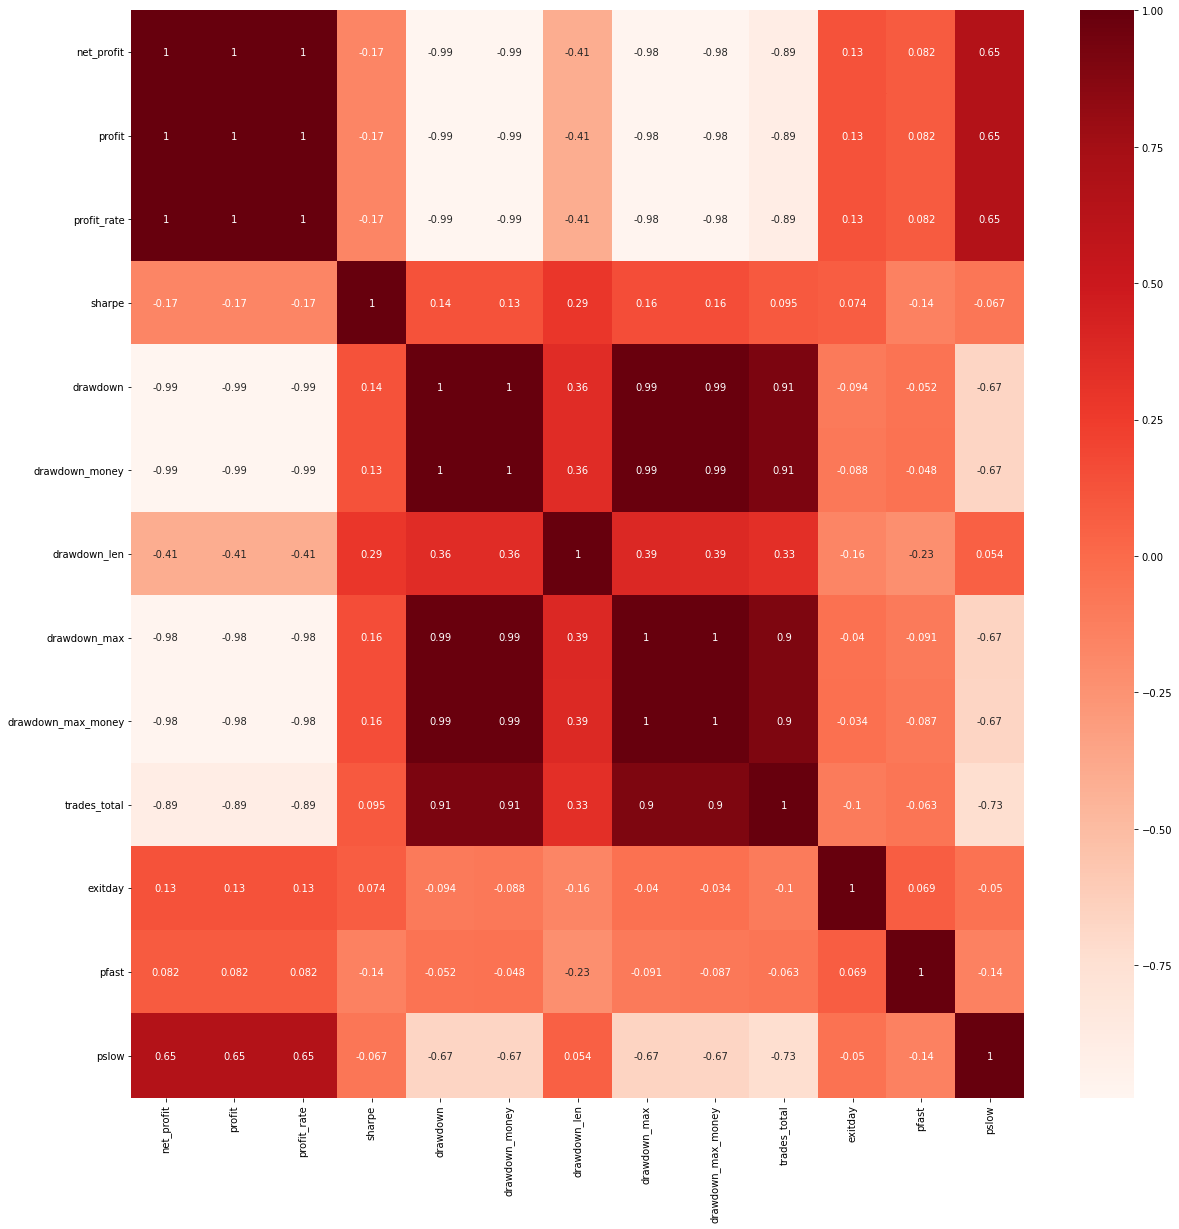

In [17]:
#%matplotlib inline
cor = df_res.corr()
matplotlib.pyplot.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
cor_target = cor['profit_rate'].abs()
# cor_target = cor_target[(cor_target < 0.9999)] # Filter from the same values
relevant_features = cor_target[[i in best_param.keys() for i in cor_target.index]].sort_values(ascending=False) # Filter from addanalyzer. Add result: or i in ['profit_rate']
print('The most correlating parameters with profit:')

name_x = relevant_features.index[0]
name_y = relevant_features.index[1]
if not IS_IN_COLAB:
    print(relevant_features)
relevant_features


The most correlating parameters with profit:


pslow      0.652054
exitday    0.132781
pfast      0.082127
Name: profit_rate, dtype: float64

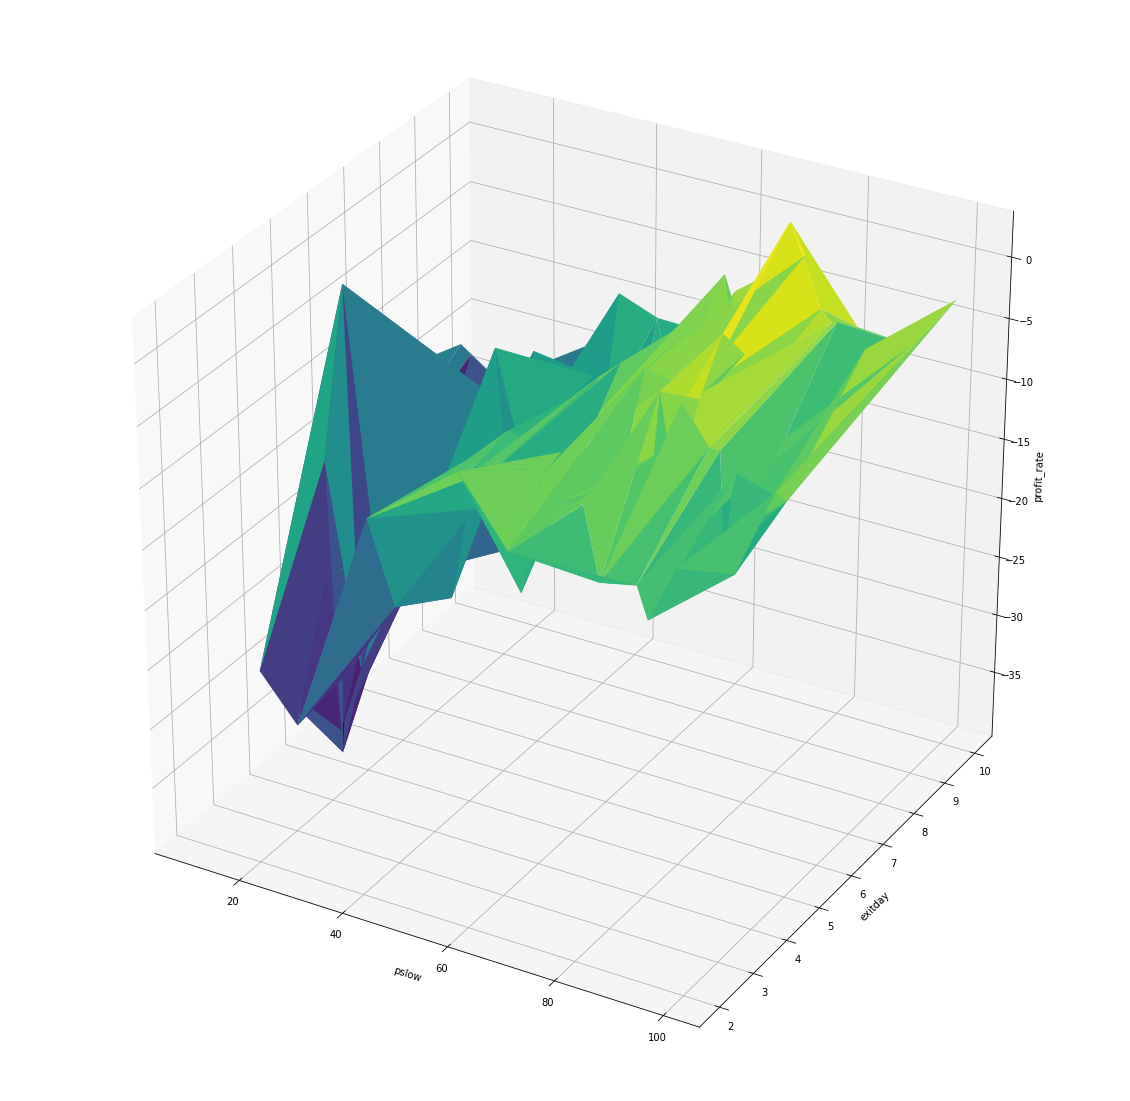

In [19]:
# Profit graph
fig_plt = plt.figure(figsize=(20, 20))
ax_plt = fig_plt.gca(projection='3d')
surf = ax_plt.plot_trisurf(df_res[name_x], df_res[name_y], df_res['profit_rate'], cmap='viridis', label="profit_rate")
ax_plt.set_xlabel(name_x)
ax_plt.set_ylabel(name_y)
ax_plt.set_zlabel('profit_rate')
fig_plt.show()
# plt.show()

In [20]:
# Max profit only for most correlated values
#%matplotlib inline
max_profit_idx = df_res.groupby([name_x, name_y])['net_profit'].transform(max) == df_res['net_profit']
print('Only the best match for most correlated parameters')
max_profit = df_res[max_profit_idx].sort_values('net_profit', ascending=False)

if not IS_IN_COLAB:
    print(max_profit)
max_profit

Only the best match for most correlated parameters


net_profit     profit  profit_rate  ...  exitday  pfast  pslow
0         0.67  24.547080         2.81  ...        9     16     75
21        0.03  23.910216         0.13  ...        5     25     75
66        0.00  23.880000         0.00  ...        5     17     17
29        0.00  23.880000         0.00  ...        5     17     17
60       -0.33  23.550660        -1.38  ...        8     17     74
..         ...        ...          ...  ...      ...    ...    ...
2        -6.74  17.143346       -28.22  ...        6     10     16
74       -6.85  17.026684       -28.69  ...        9      4     23
68       -7.62  16.258808       -31.91  ...        5      5     19
16       -8.18  15.704472       -34.25  ...        4     21     22
61       -9.49  14.393308       -39.74  ...        5     10     15

[97 rows x 13 columns]

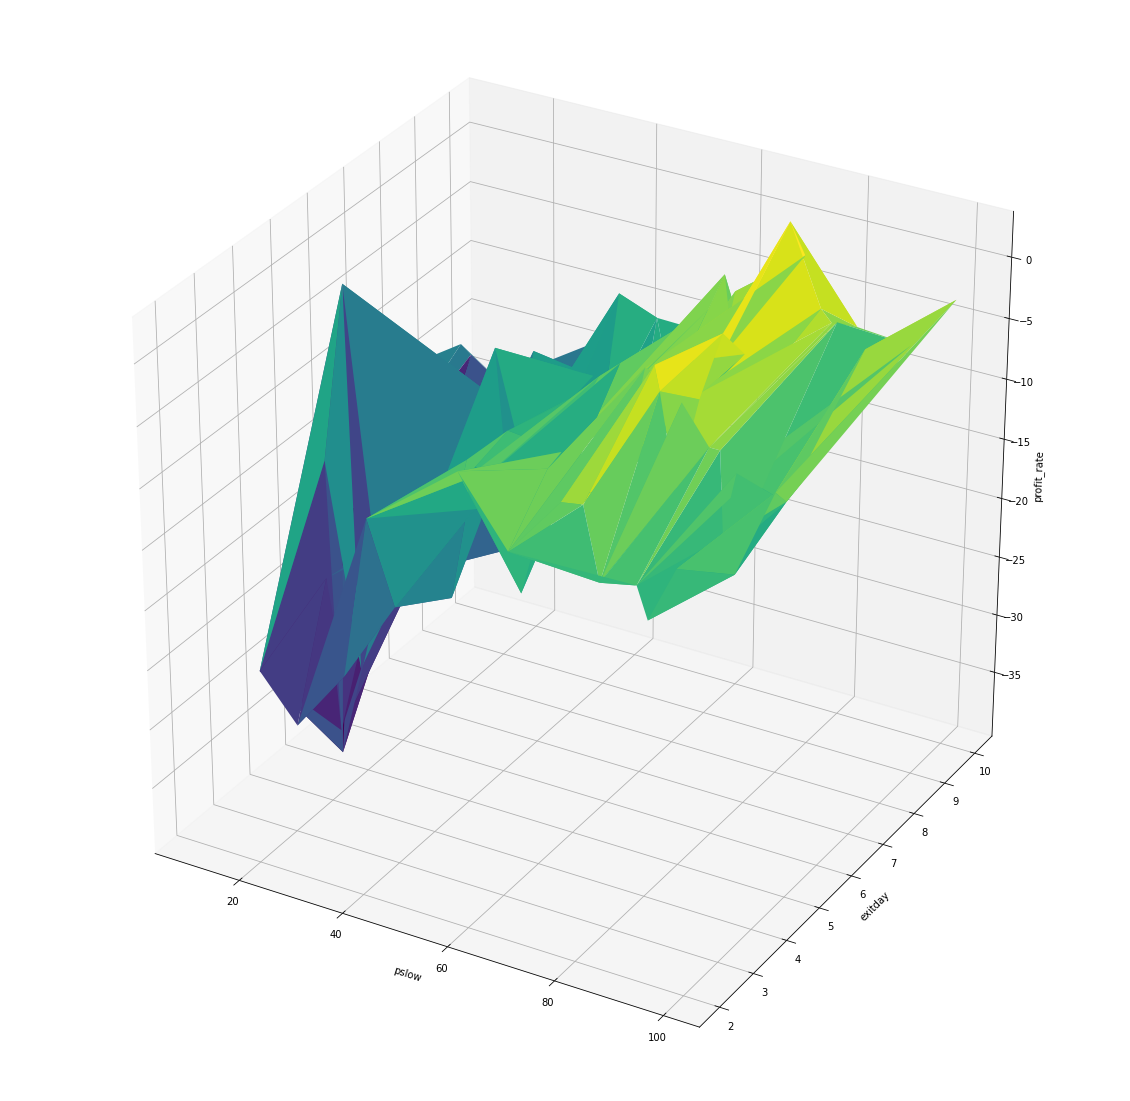

In [21]:
# Max profit graph
#%matplotlib inline
fig_plt = plt.figure(figsize=(20, 20))
ax_plt = fig_plt.gca(projection='3d')
surf = ax_plt.plot_trisurf(max_profit[name_x], max_profit[name_y], max_profit['profit_rate'], cmap='viridis', label="profit_rate")
ax_plt.set_xlabel(name_x)
ax_plt.set_ylabel(name_y)
ax_plt.set_zlabel('profit_rate')
fig_plt.show()
# plt.show()

In [22]:
# Max profit only for most correlated values with drawdown
#%matplotlib inline
# fig_drawdonw = plt.figure()
# ax_drawdonw = fig_drawdonw.add_subplot(projection='3d')
# img = ax_drawdonw.scatter(max_profit[name_x], max_profit[name_y], max_profit['profit_rate'], c=(-max_profit['drawdown']), cmap=plt.hot())
# ax_drawdonw.set_xlabel(name_x)
# ax_drawdonw.set_ylabel(name_y)
# ax_drawdonw.set_zlabel('profit_rate')
# fig_drawdonw.colorbar(img)
# plt.show()
fig = px.scatter_3d(max_profit, max_profit[name_x], max_profit[name_y], max_profit['profit_rate'], color = max_profit['drawdown'], color_continuous_scale='Inferno_r')
fig.show()